# Optimización de hiperparámetros con **Repeated K‑Fold CV**
En este notebook refinamos el baseline de Regresión Logística multietiqueta utilizando
*Repeated K‑Fold* para la búsqueda de hiperparámetros y mostramos:
* **Gráfica de λ (= 1/C)** frente a la métrica de validación promediada.
* **Curva de aprendizaje** (tamaño de entrenamiento vs F1‑micro).

## Bloque 1 – Importaciones
Se añaden `RepeatedKFold` y `learning_curve` para la nueva validación.

In [151]:
# ----- Bloque 1 -----
import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer, hamming_loss


## Bloque 2 – Ruta


In [152]:
# ----- Bloque 2 -----
if not os.path.basename(os.getcwd()) == 'Seismic-Multilabel-Event-Classifier':
    os.chdir('..')
    print('CWD ->', os.getcwd())

## Bloque 3 – Carga de datos


In [153]:
# ----- Bloque 3 -----
df = pd.read_json('data/processed/dataset_final.json')
print('Shape:', df.shape)
df.head()


Shape: (1674, 92)


,max_V,rms_V,max_H1,rms_H1,max_H2,rms_H2,duration,zcr_V,dom_freq_V,centroid_V,...,1 Stiker Slip (SS),2 Normal-Oblique (SO),3 Reverse-Oblique (RO),4-6,6-8,0-200,200-400,400-600,600-,label
0,0.000342,0.000052,0.000587,0.000111,0.000617,0.000107,321.68,2.014362,0.000000,5.447156,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
1,0.003967,0.000347,0.006399,0.000501,0.004988,0.000475,200.00,9.034548,0.781250,17.551070,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
2,0.000135,0.000023,0.000204,0.000028,0.000157,0.000026,323.79,1.429895,0.195312,2.573894,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
3,0.003166,0.000453,0.005030,0.000657,0.004669,0.000725,41.00,21.189954,14.062500,14.019404,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
4,0.000011,0.000002,0.000021,0.000003,0.000018,0.000003,180.80,3.943366,0.195312,10.936094,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-


In [154]:
print(df.columns)

Index(['max_V', 'rms_V', 'max_H1', 'rms_H1', 'max_H2', 'rms_H2', 'duration',
       'zcr_V', 'dom_freq_V', 'centroid_V', 'bandwidth_V', 'spec_ratio_V',
       'dom_freq_H1', 'centroid_H1', 'bandwidth_H1', 'spec_ratio_H1',
       'dom_freq_H2', 'centroid_H2', 'bandwidth_H2', 'spec_ratio_H2',
       'FFT_PCA_1', 'FFT_PCA_2', 'FFT_PCA_3', 'FFT_PCA_4', 'FFT_PCA_5',
       'FFT_PCA_6', 'FFT_PCA_7', 'FFT_PCA_8', 'FFT_PCA_9', 'FFT_PCA_10',
       'FFT_PCA_11', 'FFT_PCA_12', 'FFT_PCA_13', 'FFT_PCA_14', 'FFT_PCA_15',
       'FFT_PCA_16', 'FFT_PCA_17', 'FFT_PCA_18', 'FFT_PCA_19', 'FFT_PCA_20',
       'FFT_PCA_21', 'FFT_PCA_22', 'FFT_PCA_23', 'FFT_PCA_24', 'FFT_PCA_25',
       'FFT_PCA_26', 'FFT_PCA_27', 'FFT_PCA_28', 'FFT_PCA_29', 'FFT_PCA_30',
       'FFT_PCA_31', 'FFT_PCA_32', 'FFT_PCA_33', 'FFT_PCA_34', 'FFT_PCA_35',
       'FFT_PCA_36', 'FFT_PCA_37', 'FFT_PCA_38', 'FFT_PCA_39', 'FFT_PCA_40',
       'FFT_PCA_41', 'FFT_PCA_42', 'FFT_PCA_43', 'FFT_PCA_44', 'FFT_PCA_45',
       'FFT_PCA_46', 'FF

## Bloque 4 – Separación X / y


In [155]:
# ----- Bloque 4 -----
label_cols = ['1 Stiker Slip (SS)','2 Normal-Oblique (SO)','3 Reverse-Oblique (RO)',
              '4-6','6-8','0-200','200-400','400-600','600-']
drop_cols = ['Archivo','Falla_lbl','Mag_lbl','Vs_lbl','Combo', 'label'] + label_cols
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values
y = df[label_cols].values
print('X:', X.shape, ' y:', y.shape)

X: (1674, 82)  y: (1674, 9)


## Bloque 5 – Split hold‑out Test


In [156]:
# ----- Bloque 5 -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (1339, 82)  Test: (335, 82)


## Bloque 6 – Pipeline base


In [157]:
# ----- Bloque 6 -----
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='lbfgs')))
])

## Bloque 7 – Grid y Repeated K‑Fold


In [158]:
# ----- Bloque 7 -----
C_values = np.logspace(-3, 2, 10)  # 0.001 → 100
param_grid = {'clf__estimator__C': C_values}

rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)  # 15 ejecuciones
scorer = make_scorer(f1_score, average='micro')

grid = GridSearchCV(base_pipe, param_grid, scoring=scorer,
                    cv=rkf, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print('Mejor C:', grid.best_params_['clf__estimator__C'])
print('F1‑micro CV:', grid.best_score_)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__estimator__C=0.001; total time=   0.0s
[CV] END ............................clf__es

## Bloque 8 – Gráfica λ vs F1‑CV


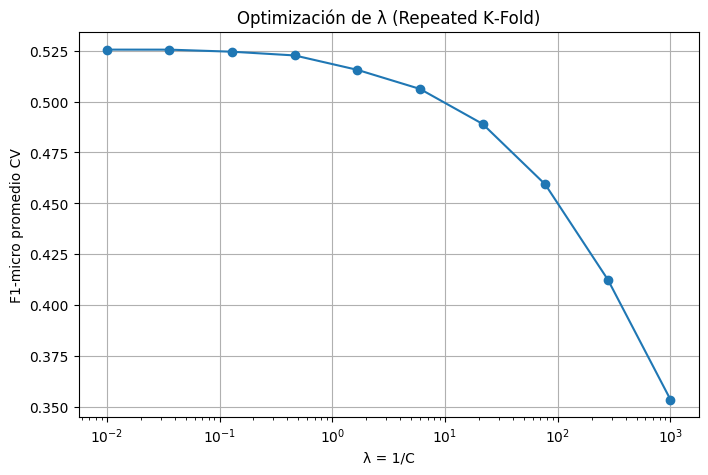

In [159]:
# ----- Bloque 8 -----
results = pd.DataFrame(grid.cv_results_)
results['lambda'] = 1 / results['param_clf__estimator__C'].astype(float)
means = results.groupby('lambda')['mean_test_score'].mean().sort_index()

plt.figure(figsize=(8,5))
plt.plot(means.index, means.values, marker='o')
plt.xscale('log')
plt.xlabel('λ = 1/C')
plt.ylabel('F1‑micro promedio CV')
plt.title('Optimización de λ (Repeated K‑Fold)')
plt.grid(True)
plt.show()

## Bloque 9 – Curva de aprendizaje


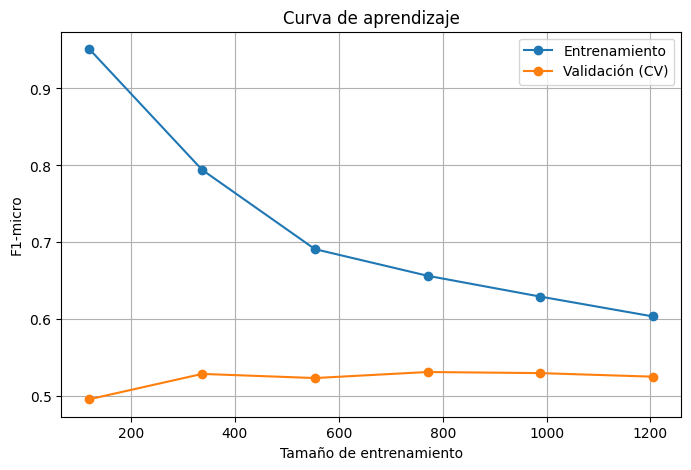

In [160]:
# ----- Bloque 9 -----
best_C = grid.best_params_['clf__estimator__C']
best_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(LogisticRegression(C=best_C, max_iter=1000, solver='lbfgs')))
])

train_sizes, train_scores, val_scores = learning_curve(
    best_pipe, X_train, y_train,
    cv=rkf, scoring=scorer,
    train_sizes=np.linspace(0.1, 1.0, 6), n_jobs=-1)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
plt.plot(train_sizes, val_mean, 'o-', label='Validación (CV)')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1‑micro')
plt.title('Curva de aprendizaje')
plt.legend()
plt.grid(True)
plt.show()

## Bloque 10 – Evaluación en Test


In [161]:
# ----- Bloque 10 -----
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
print('Test F1‑micro:', f1_score(y_test, y_pred, average='micro'))
print('Test Hamming loss:', hamming_loss(y_test, y_pred))

Test F1‑micro: 0.5504694835680751
Test Hamming loss: 0.25406301824212274


## Bloque 11 – Guardar modelo


In [162]:
# ----- Bloque 11 -----
os.makedirs('models', exist_ok=True)
joblib.dump(best_pipe, 'models/logreg_repkfold.pkl')
print('Modelo guardado en models/logreg_repkfold.pkl')

Modelo guardado en models/logreg_repkfold.pkl
